In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import torch
from keras import layers
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import metrics
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.models import Model
from keras.metrics import AUC
import keras

Image Preprocessing

In [3]:
# Set the path to your dataset
BASE_PATH = "C:\\DL Testing Set"

# Step 1: Image Preprocessing
image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


            labels  encoded_labels
0          Araneae               0
4776    Coleoptera               1
5315       Diptera               2
5892     Hemiptera               3
6580   Hymenoptera               4
7251   Lepidoptera               5
10649      Odonata               6


In [4]:
def img_display(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg


Model Modification for Insect Classification

In [5]:
class InsectDataset(Dataset):
    def __init__(self, img_data, img_path, transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        self.filenames = []  # Store filenames

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, index):
        img_name = os.path.join(self.img_path, self.img_data.loc[index, 'labels'], self.img_data.loc[index, 'Images'])
        self.filenames.append(img_name)  # Store filename
        image = Image.open(img_name)
        image = image.resize((224, 224))  # Resize images
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        if self.transform is not None:
            image = self.transform(image)  # Apply transformation here
        return image, label



In [6]:
class InsectDataset(Dataset):
    def __init__(self, img_data, img_path, transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, index):
        img_name = os.path.join(self.img_path, self.img_data.loc[index, 'labels'], self.img_data.loc[index, 'Images'])
        image = Image.open(img_name)
        image = image.resize((224, 224))  # Resize images
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        if self.transform is not None:
            image = self.transform(image)  # Apply transformation here
        return image, label

Training the Insect Classification Model

In [7]:
# Step 3: Training the Models
# Split the data
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Number of classes (insects)
num_classes = len(unique_labels)

# Create data generators
train_gen = InsectDataset(train_data, BASE_PATH, transform=transform)
test_gen = InsectDataset(test_data, BASE_PATH, transform=transform)

# Define batch size
batch_size = 64   # You can adjust this based on your system's capacity

# Assuming you have train_gen and test_gen already defined as ImageDataGenerator instances
train_gen = ImageDataGenerator(rescale=(1./255.), validation_split=0.2)
test_gen = ImageDataGenerator(rescale=(1./255.))

In [7]:
# Step 2: Model Modification for Insect Classification

def get_custom_model(num_classes):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False
    base_model_output = base_model.output

    # Custom Layers
    x = Conv2D(64, kernel_size=(3, 3), padding='same', strides=2, activation="relu")(base_model_output)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=1, padding='same')(x)

    x = Conv2D(32, kernel_size=(5, 5), padding='same', strides=1, activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=1, padding='same')(x)

    x = Conv2D(256, kernel_size=(2, 2), padding='same', strides=1, activation="relu")(x)
    x = BatchNormalization()(x)

    x = Flatten()(x)

    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Adjust this part to handle variable number of classes
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model

In [8]:
# Create the model
custom_model = get_custom_model(num_classes)

In [32]:
from keras.models import load_model

# Compile the model
custom_model.compile(loss="categorical_crossentropy",
                      optimizer=SGD(learning_rate=0.001, momentum=0.9),
                      metrics=['accuracy', metrics.Recall(), metrics.Precision(), metrics.AUC()])

# Assuming you have train_dir and val_dir already defined
train_dir = BASE_PATH
val_dir = BASE_PATH

# Train AlexNet
history_custom = custom_model.fit(
    train_gen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical', 
                                  subset='training'),
    epochs=10,
    validation_data=train_gen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=batch_size, 
                                                  class_mode='categorical', subset='validation')
    #,callbacks=[EarlyStopping(patience=3)]
)


# Save the model
custom_model.save("C:/Deep Learning/Project/Classification Models/mobinceptionv3_model.h5")

# Save training history to a CSV file
history_df = pd.DataFrame(history_custom.history)
history_df.to_csv("C:/Deep Learning/Project/Classification Models/mobinceptionv3_history.csv", index=False)



Found 11628 images belonging to 7 classes.
Found 2902 images belonging to 7 classes.
Epoch 1/10
182/182 [==============================] - 7401s 41s/step - loss: 0.8823 - accuracy: 0.7220 - recall_4: 0.6652 - precision_4: 0.8061 - auc_4: 0.9354 - val_loss: 0.9751 - val_accuracy: 0.6816 - val_recall_4: 0.5024 - val_precision_4: 0.8945 - val_auc_4: 0.9192
Epoch 2/10
182/182 [==============================] - 5696s 31s/step - loss: 0.5341 - accuracy: 0.8261 - recall_4: 0.7871 - precision_4: 0.8759 - auc_4: 0.9742 - val_loss: 0.8328 - val_accuracy: 0.7209 - val_recall_4: 0.6513 - val_precision_4: 0.8046 - val_auc_4: 0.9407
Epoch 3/10
182/182 [==============================] - 5813s 32s/step - loss: 0.3742 - accuracy: 0.8727 - recall_4: 0.8448 - precision_4: 0.9079 - auc_4: 0.9868 - val_loss: 0.8600 - val_accuracy: 0.7326 - val_recall_4: 0.6988 - val_precision_4: 0.7803 - val_auc_4: 0.9437
Epoch 4/10
182/182 [==============================] - 4400s 24s/step - loss: 0.2518 - accuracy: 0.9144

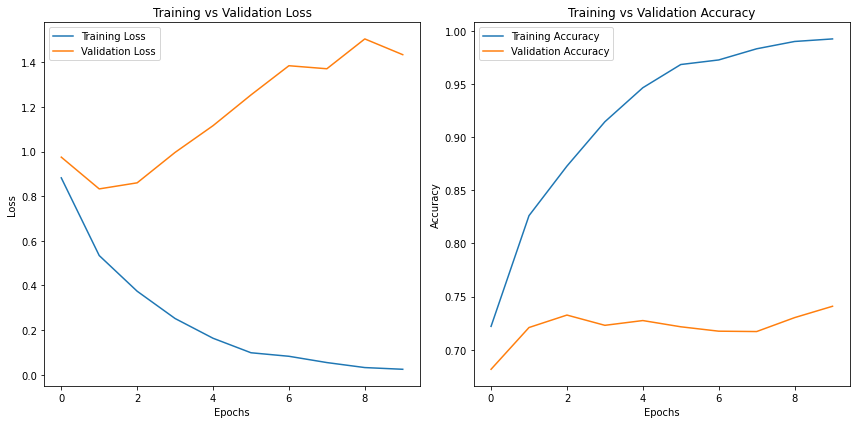

In [33]:
import pandas as pd
import matplotlib.pyplot as plt 

# Load the data from the CSV file
file_path = "C:/Deep Learning/Project/Classification Models/mobinceptionv3_history.csv"  # Update with the correct file path
history_data = pd.read_csv(file_path)

# Plot Training vs Validation Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_data['loss'], label='Training Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot Training vs Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_data['accuracy'], label='Training Accuracy')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


# Testing Prediction on Unlabeled Images

1/1 [==============================] - 4s 4s/step


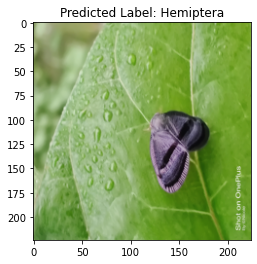

Predicted Label for the New Image: Hemiptera


In [9]:
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/mobinceptionv3_model.h5")


# Specify the path to the new, unlabeled image
new_image_path = "C:/DL Small Set/Hemiptera/IMG_20210928_072325.jpg"

# Load and preprocess the new image
new_image = Image.open(new_image_path)
new_image = new_image.resize((224, 224))
new_image_array = np.array(new_image) / 255.0  # Normalize pixel values
new_image_array = np.expand_dims(new_image_array, axis=0)  # Add batch dimension

# Make predictions on the new image
new_image_prediction = loaded_model.predict(new_image_array)

# Convert the prediction to a class label
predicted_label = lb.inverse_transform(new_image_prediction.argmax(axis=1))[0]

# Display the new image along with the predicted label
plt.imshow(new_image)
plt.title(f"Predicted Label: {predicted_label}")
plt.show()

print("Predicted Label for the New Image:", predicted_label)


1/1 [==============================] - 3s 3s/step


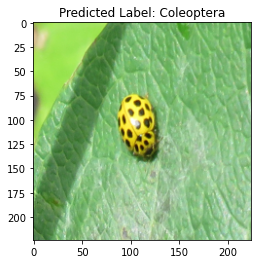

Predicted Label for the New Image: Coleoptera


In [12]:
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/mobinceptionv3_model.h5")



# Specify the path to the new, unlabeled image
new_image_path = "C:/kaggle/input/ArTaxOr/Coleoptera/0bd077deb271.jpg"

# Load and preprocess the new image
new_image = Image.open(new_image_path)
new_image = new_image.resize((224, 224))
new_image_array = np.array(new_image) / 255.0  # Normalize pixel values
new_image_array = np.expand_dims(new_image_array, axis=0)  # Add batch dimension

# Make predictions on the new image
new_image_prediction = loaded_model.predict(new_image_array)

# Convert the prediction to a class label
predicted_label = lb.inverse_transform(new_image_prediction.argmax(axis=1))[0]

# Display the new image along with the predicted label
plt.imshow(new_image)
plt.title(f"Predicted Label: {predicted_label}")
plt.show()

print("Predicted Label for the New Image:", predicted_label)


1/1 [==============================] - 1s 1s/step


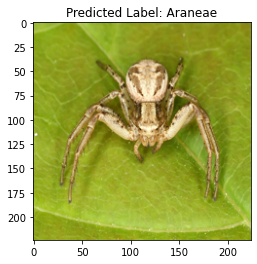

Predicted Label for the New Image: Araneae


In [14]:
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/mobinceptionv3_model.h5")

# Specify the path to the new, unlabeled image
new_image_path = "C:/kaggle/input/ArTaxOr/Araneae/fa6b4011c1f0.jpg"

# Load and preprocess the new image
new_image = Image.open(new_image_path)
new_image = new_image.resize((224, 224))
new_image_array = np.array(new_image) / 255.0  # Normalize pixel values
new_image_array = np.expand_dims(new_image_array, axis=0)  # Add batch dimension

# Make predictions on the new image
new_image_prediction = loaded_model.predict(new_image_array)

# Convert the prediction to a class label
predicted_label = lb.inverse_transform(new_image_prediction.argmax(axis=1))[0]

# Display the new image along with the predicted label
plt.imshow(new_image)
plt.title(f"Predicted Label: {predicted_label}")
plt.show()

print("Predicted Label for the New Image:", predicted_label)


# Testing Prediction on Mobile Corpus

In [17]:
from keras.preprocessing.image import ImageDataGenerator

# Assuming you have train_gen and test_gen already defined as ImageDataGenerator instances
train_gen = ImageDataGenerator(rescale=(1./255.), validation_split=0.2)
test_gen = ImageDataGenerator(rescale=(1./255.))

# Specify the path to the test set
test_dir = "C:\\DL Testing Set"

# Evaluate the model on the test set
test_results = loaded_model.evaluate(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))

# Display the evaluation results
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])


Found 15210 images belonging to 10 classes.
238/238 [==============================] - 5686s 24s/step - loss: 0.5105 - accuracy: 0.8361 - recall_1: 0.7815 - precision_1: 0.8929 - auc_1: 0.9838
Test Loss: 0.5105234980583191
Test Accuracy: 0.8360946774482727


1/1 [==============================] - 0s 74ms/step


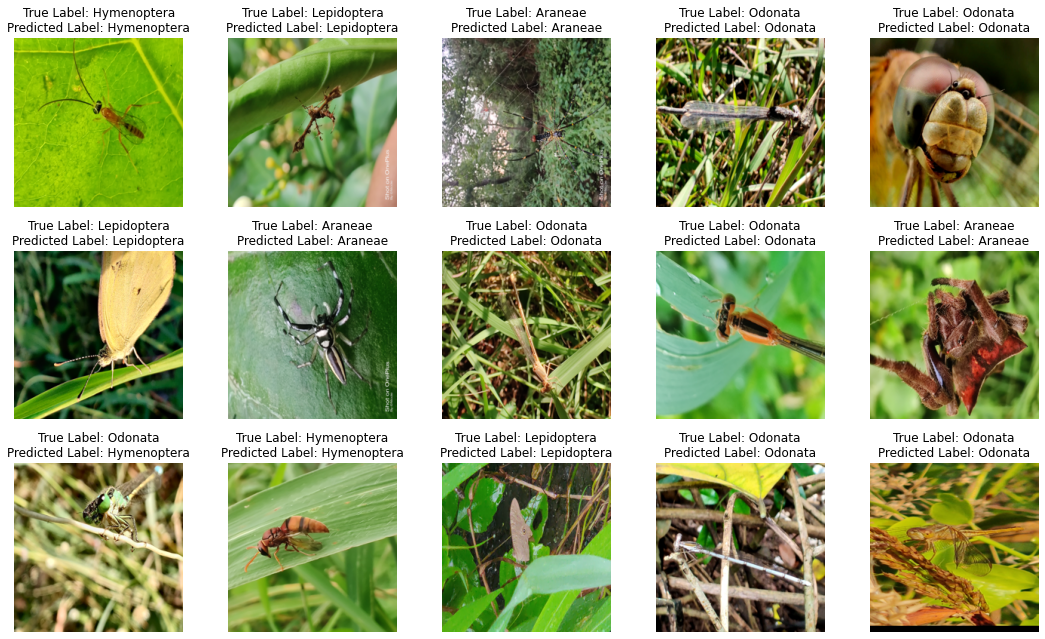

Found 14530 images belonging to 7 classes.
228/228 [==============================] - 3366s 15s/step - loss: 0.2935 - accuracy: 0.9467 - recall_4: 0.9450 - precision_4: 0.9493 - auc_4: 0.9858
Test Loss: 0.2934747040271759
Test Accuracy: 0.94673091173172


In [21]:
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder


# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/mobinceptionv3_model.h5")

# Modify the DataFrame to include the filepath for each image and assign a number to each image
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for index, row in data.iterrows()]
data['image_number'] = range(1, len(data) + 1)

# Select 15 random images
random_image_numbers = np.random.choice(data['image_number'], size=15, replace=False)

# Create a 3x5 subplot grid
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
fig.tight_layout()

# Loop over the selected random images
for i, image_number in enumerate(random_image_numbers):
    # Retrieve path and true label
    selected_image = data[data['image_number'] == image_number]
    img_path = selected_image['filepaths'].values[0]
    true_label = lb.inverse_transform([selected_image['encoded_labels'].values[0]])[0]

    # Load and preprocess the image
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)

    # Convert the prediction to a class label
    predicted_label = lb.inverse_transform(img_prediction.argmax(axis=1))[0]

    # Plot the image along with true and predicted labels
    axs[i // 5, i % 5].imshow(img)
    axs[i // 5, i % 5].axis('off')
    axs[i // 5, i % 5].set_title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")

# Show the plot
plt.show()

# Specify the path to the test set
test_dir = "C:\\DL Testing Set"

# Evaluate the model on the test set
test_results = loaded_model.evaluate(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))

# Display the evaluation results
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])

# Test on ArTaxOr

In [38]:
from keras.preprocessing.image import ImageDataGenerator

# Assuming you have train_gen and test_gen already defined as ImageDataGenerator instances
train_gen = ImageDataGenerator(rescale=(1./255.), validation_split=0.2)
test_gen = ImageDataGenerator(rescale=(1./255.))

# Specify the path to the test set
test_dir = "C:\\kaggle\\input\\ArTaxOr"

# Evaluate the model on the test set
test_results = loaded_model.evaluate(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))

# Display the evaluation results
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])

Found 15376 images belonging to 7 classes.
241/241 [==============================] - 1676s 7s/step - loss: 3.4045 - accuracy: 0.4879 - recall_4: 0.4787 - precision_4: 0.5010 - auc_4: 0.7729
Test Loss: 3.4045255184173584
Test Accuracy: 0.4879032373428345


            labels  encoded_labels
0          Araneae               0
2418    Coleoptera               1
4528       Diptera               2
6558     Hemiptera               3
8945   Hymenoptera               4
10993  Lepidoptera               5
13099      Odonata               6
Found 15376 images belonging to 7 classes.
241/241 [==============================] - 2725s 11s/step - loss: 3.4045 - accuracy: 0.4879 - recall_4: 0.4787 - precision_4: 0.5010 - auc_4: 0.7729
Found 15376 images belonging to 7 classes.
241/241 [==============================] - 2771s 11s/step
Inceptionv3 Test Loss: 3.4045250415802
Inceptionv3 Test Accuracy: 0.4879032373428345
1/1 [==============================] - 0s 116ms/step


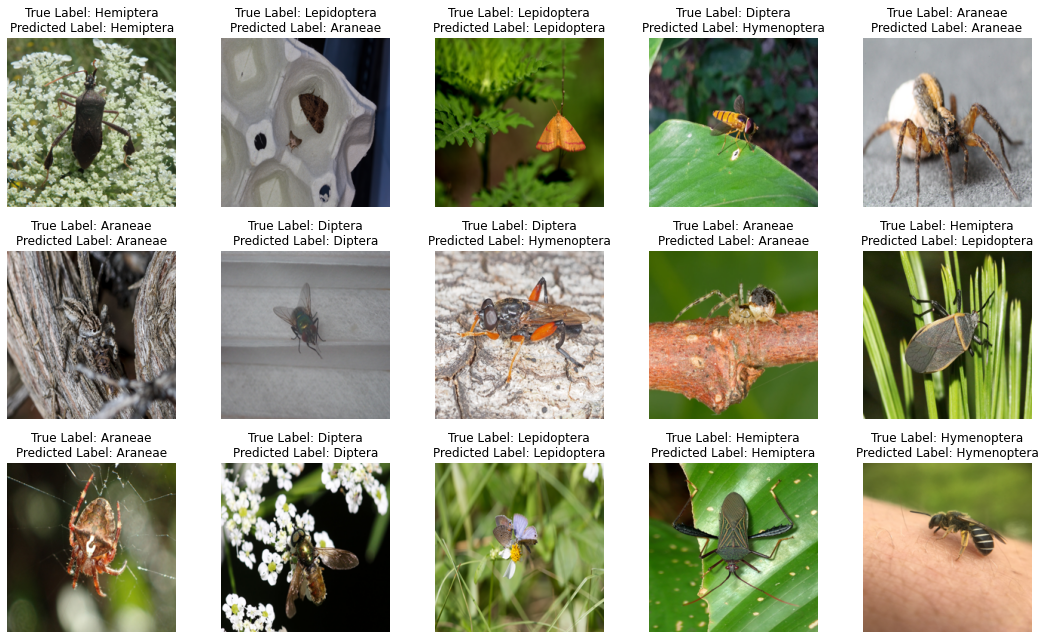

In [14]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model


# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/mobinceptionv3_model.h5")

# Set the path to the test set
test_dir = "C:\\kaggle\\input\\ArTaxOr"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\kaggle\\input\\ArTaxOr"  # Change this to the correct path
image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 64

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]



# Retrieve true labels from the data dataframe
true_labels = []

# Create a list of indices and shuffle it
indices = list(range(len(data)))
np.random.shuffle(indices)

for i in range(15):  # Select 15 random images
    random_index = indices[i]
    img_name = data.iloc[random_index]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    true_labels.append(true_label)

# Convert the true labels to numpy array
true_labels = np.array(true_labels)

# Evaluate the model on the test set and make predictions
test_results = loaded_model.evaluate(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))
predictions = loaded_model.predict(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))

# Display the evaluation results
print("Inceptionv3 Test Loss:", test_results[0])
print("Inceptionv3 Test Accuracy:", test_results[1])


# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Create a 3x5 subplot grid
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
fig.tight_layout()

# Loop over the selected random images
for i in range(len(true_labels)):
    img_name = data.iloc[indices[i]]['Images']
    img_path = os.path.join(BASE_PATH, data.iloc[indices[i]]['labels'], img_name)
    true_label = lb.inverse_transform([true_labels[i]])[0]

    # Load and preprocess the image
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)

    # Convert the prediction to a class label
    predicted_label = lb.inverse_transform(img_prediction.argmax(axis=1))[0]

    # Plot the image along with true and predicted labels
    axs[i // 5, i % 5].imshow(img)
    axs[i // 5, i % 5].axis('off')
    axs[i // 5, i % 5].set_title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")

# Show the plot
plt.show()



# A mixture of images from both datasets - ArTaxOR and Mobile Corpus

In [41]:
from keras.preprocessing.image import ImageDataGenerator

# Assuming you have train_gen and test_gen already defined as ImageDataGenerator instances
train_gen = ImageDataGenerator(rescale=(1./255.), validation_split=0.2)
test_gen = ImageDataGenerator(rescale=(1./255.))

# Specify the path to the test set
test_dir = "C:\\DL Small Artax_Mobl Mix"

# Evaluate the model on the test set
test_results = loaded_model.evaluate(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))

# Display the evaluation results
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])

Found 229 images belonging to 7 classes.
4/4 [==============================] - 117s 27s/step - loss: 1.8449 - accuracy: 0.7293 - recall_4: 0.7249 - precision_4: 0.7511 - auc_4: 0.8984
Test Loss: 1.844909429550171
Test Accuracy: 0.7292576432228088


          labels  encoded_labels
0        Araneae               0
31    Coleoptera               1
66       Diptera               2
96     Hemiptera               3
130  Hymenoptera               4
164  Lepidoptera               5
196      Odonata               6
Found 229 images belonging to 7 classes.
4/4 [==============================] - 77s 18s/step - loss: 1.8449 - accuracy: 0.7293 - recall_4: 0.7249 - precision_4: 0.7511 - auc_4: 0.8984
Found 229 images belonging to 7 classes.
4/4 [==============================] - 80s 18s/step
Inception_Mod Test Loss: 1.8449093103408813
Inception_Mod Test Accuracy: 0.7292576432228088
1/1 [==============================] - 0s 94ms/step


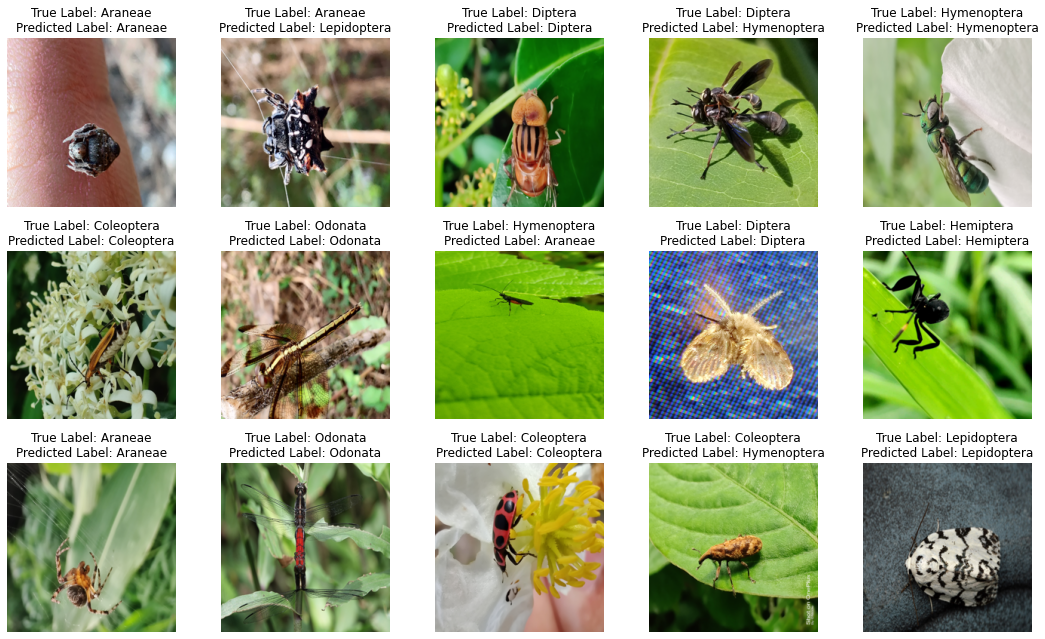

In [15]:
from keras.models import load_model
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/mobinceptionv3_model.h5")

# Set the path to the test set
test_dir = "C:\\DL Small Artax_Mobl Mix"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\DL Small Artax_Mobl Mix"  # Change this to the correct path
image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 64

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]



# Retrieve true labels from the data dataframe
true_labels = []

# Create a list of indices and shuffle it
indices = list(range(len(data)))
np.random.shuffle(indices)

for i in range(15):  # Select 15 random images
    random_index = indices[i]
    img_name = data.iloc[random_index]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    true_labels.append(true_label)

# Convert the true labels to numpy array
true_labels = np.array(true_labels)

# Evaluate the model on the test set and make predictions
test_results = loaded_model.evaluate(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))
predictions = loaded_model.predict(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))


# Display the evaluation results
print("Inception_Mod Test Loss:", test_results[0])
print("Inception_Mod Test Accuracy:", test_results[1])


# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Create a 3x5 subplot grid
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
fig.tight_layout()

# Loop over the selected random images
for i in range(len(true_labels)):
    img_name = data.iloc[indices[i]]['Images']
    img_path = os.path.join(BASE_PATH, data.iloc[indices[i]]['labels'], img_name)
    true_label = lb.inverse_transform([true_labels[i]])[0]

    # Load and preprocess the image
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)

    # Convert the prediction to a class label
    predicted_label = lb.inverse_transform(img_prediction.argmax(axis=1))[0]

    # Plot the image along with true and predicted labels
    axs[i // 5, i % 5].imshow(img)
    axs[i // 5, i % 5].axis('off')
    axs[i // 5, i % 5].set_title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")

# Show the plot
plt.show()





# Confusion Matrix for Mobile-ArTaxOR Mix set

          labels  encoded_labels
0        Araneae               0
31    Coleoptera               1
66       Diptera               2
96     Hemiptera               3
130  Hymenoptera               4
164  Lepidoptera               5
196      Odonata               6
1/1 [==============================] - 0s 89ms/step


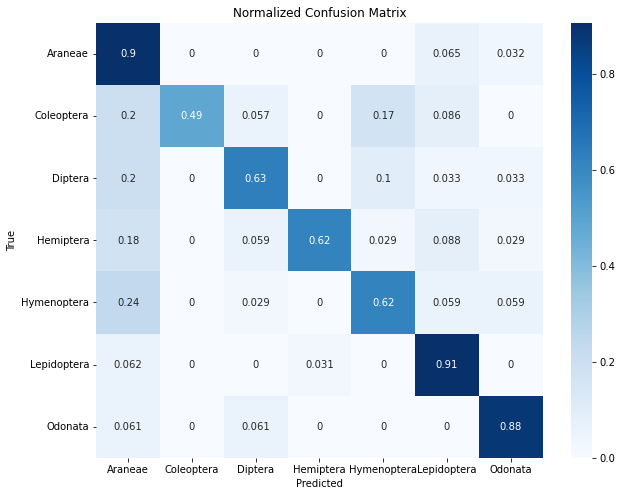

Classification Report:
              precision    recall  f1-score   support

     Araneae       0.47      0.90      0.62        31
  Coleoptera       1.00      0.49      0.65        35
     Diptera       0.73      0.63      0.68        30
   Hemiptera       0.95      0.62      0.75        34
 Hymenoptera       0.68      0.62      0.65        34
 Lepidoptera       0.72      0.91      0.81        32
     Odonata       0.85      0.88      0.87        33

    accuracy                           0.72       229
   macro avg       0.77      0.72      0.72       229
weighted avg       0.78      0.72      0.72       229



In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from keras.models import load_model
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/mobinceptionv3_model.h5")

# Set the path to the test set
test_dir = "C:\\DL Small Artax_Mobl Mix"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\DL Small Artax_Mobl Mix"  # Change this to the correct path

image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 64

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]

# Retrieve true labels and predictions for the entire test set
true_labels = []
predicted_labels = []

# Loop over the entire test set
for i in range(len(data)):
    img_name = data.iloc[i]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    
    # Load and preprocess the image
    img_path = os.path.join(BASE_PATH, data.iloc[i]['labels'], img_name)
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)
    predicted_label = np.argmax(img_prediction)

    true_labels.append(true_label)
    predicted_labels.append(predicted_label)

# Convert the lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Create a confusion matrix for the entire test set
cm = confusion_matrix(true_labels, predicted_labels)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap of the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=unique_labels['labels'], yticklabels=unique_labels['labels'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print the classification report for the entire test set
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=unique_labels['labels']))

# Confusion Matrix for ArTaxOr

            labels  encoded_labels
0          Araneae               0
2418    Coleoptera               1
4528       Diptera               2
6558     Hemiptera               3
8945   Hymenoptera               4
10993  Lepidoptera               5
13099      Odonata               6
1/1 [==============================] - 5s 5s/step


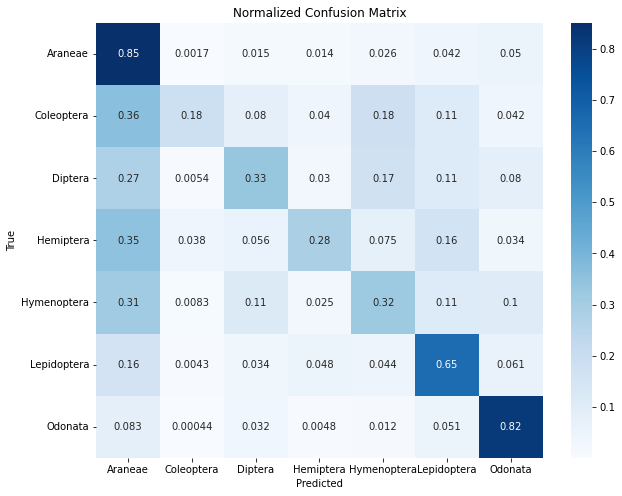

Classification Report:
              precision    recall  f1-score   support

     Araneae       0.38      0.85      0.53      2418
  Coleoptera       0.74      0.18      0.29      2112
     Diptera       0.49      0.33      0.40      2028
   Hemiptera       0.66      0.28      0.40      2387
 Hymenoptera       0.38      0.32      0.35      2048
 Lepidoptera       0.52      0.65      0.58      2106
     Odonata       0.70      0.82      0.75      2277

    accuracy                           0.50     15376
   macro avg       0.55      0.49      0.47     15376
weighted avg       0.55      0.50      0.47     15376



In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from keras.models import load_model
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt


# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/mobinceptionv3_model.h5")

# Set the path to the test set
test_dir = "C:\\kaggle\\input\\ArTaxOr"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\kaggle\\input\\ArTaxOr"  # Change this to the correct path
image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 256

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]

# Retrieve true labels and predictions for the entire test set
true_labels = []
predicted_labels = []

# Loop over the entire test set
for i in range(len(data)):
    img_name = data.iloc[i]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    
    # Load and preprocess the image
    img_path = os.path.join(BASE_PATH, data.iloc[i]['labels'], img_name)
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)
    predicted_label = np.argmax(img_prediction)

    true_labels.append(true_label)
    predicted_labels.append(predicted_label)

# Convert the lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Create a confusion matrix for the entire test set
cm = confusion_matrix(true_labels, predicted_labels)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap of the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=unique_labels['labels'], yticklabels=unique_labels['labels'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print the classification report for the entire test set
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=unique_labels['labels']))


# Confusion Matrix for Mobile Corpus

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import load_model
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/mobinceptionv3_model.h5")

# Set the path to the test set
test_dir = "C:\\DL Testing Set"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\DL Testing Set"  # Change this to the correct path
image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 512

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]

# Retrieve true labels and predictions for the entire test set
true_labels = []
predicted_labels = []

# Loop over the entire test set
for i in range(len(data)):
    img_name = data.iloc[i]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    
    # Load and preprocess the image
    img_path = os.path.join(BASE_PATH, data.iloc[i]['labels'], img_name)
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)
    predicted_label = np.argmax(img_prediction)

    true_labels.append(true_label)
    predicted_labels.append(predicted_label)

# Convert the lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Create a confusion matrix for the entire test set
cm = confusion_matrix(true_labels, predicted_labels)

# Create a normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=unique_labels['labels'], 
            yticklabels=unique_labels['labels'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Alternatively, you can use the plot_confusion_matrix function
# Note: Ensure that you have scikit-learn version 0.22 or newer for this function
fig, ax = plt.subplots(figsize=(10, 8))
plot_confusion_matrix(loaded_model, X_test, y_test, display_labels=unique_labels['labels'], cmap='Blues', 
                      ax=ax, normalize='true')
plt.title('Normalized Confusion Matrix')
plt.show()

# Print the classification report for the entire test set
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=unique_labels['labels']))

            labels  encoded_labels
0          Araneae               0
4776    Coleoptera               1
5315       Diptera               2
5892     Hemiptera               3
6580   Hymenoptera               4
7251   Lepidoptera               5
10649      Odonata               6
1/1 [==============================] - 14s 14s/step


In [13]:
loaded_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_194 (Conv2D)            (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_194 (Batch  (None, 111, 111, 32  96         ['conv2d_194[0][0]']             
 Normalization)                 )                                                           

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from keras.applications.inception_v3 import InceptionV3

def get_custom_model(num_classes):
    model = Sequential([
        # Base InceptionV3 model
        InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
        
        # Custom Layers
        Conv2D(64, kernel_size=(3, 3), padding='same', strides=2, activation="relu"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=1, padding='same'),
        
        Conv2D(32, kernel_size=(5, 5), padding='same', strides=1, activation="relu"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=1, padding='same'),
        
        Conv2D(256, kernel_size=(2, 2), padding='same', strides=1, activation="relu"),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(2048, activation='relu'),
        Dropout(0.5),
        
        # Output layer with softmax activation
        Dense(num_classes, activation='softmax')
    ])
    
    return model

num_classes = 7  # Replace with the actual number of classes
custinception_model = get_custom_model(num_classes)
custinception_model.summary()